# 📊 Step 3: Data Cleaning

## Magnificent 7 Stock Prediction Project

### Objectives:
1. Handle missing values (if any)
2. Detect and handle outliers
3. Standardize data formats
4. Validate data integrity
5. Create clean dataset for feature engineering

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Magnificent 7 tickers
MAGNIFICENT_7 = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft', 
    'NVDA': 'NVIDIA',
    'TSLA': 'Tesla',
    'AMZN': 'Amazon',
    'META': 'Meta',
    'GOOGL': 'Google'
}
TICKERS = list(MAGNIFICENT_7.keys())

print('✅ Libraries loaded successfully')
print(f'📊 Processing {len(TICKERS)} stocks: {TICKERS}')

✅ Libraries loaded successfully
📊 Processing 7 stocks: ['AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'META', 'GOOGL']


In [2]:
# Load raw data for each stock
stock_data = {}
for ticker in TICKERS:
    file_path = f'../data/raw/{ticker}_raw.csv'
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    stock_data[ticker] = df
    print(f'✅ {ticker}: {len(df)} rows, columns: {list(df.columns)}')

# Load market indices
df_indices = pd.read_csv('../data/raw/market_indices.csv', index_col='Date', parse_dates=True)
print(f'\n✅ Market indices loaded: {list(df_indices.columns)}')

# Load daily returns from EDA
daily_returns = pd.read_csv('../data/processed/daily_returns.csv', index_col='Date', parse_dates=True)
print(f'✅ Daily returns loaded: {daily_returns.shape}')

✅ AAPL: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ MSFT: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ NVDA: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ TSLA: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ AMZN: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ META: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']
✅ GOOGL: 2021 rows, columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits']

✅ Market indices loaded: ['GSPC', 'IXIC', 'VIX']
✅ Daily returns loaded: (2020, 7)


## 2. Data Quality Assessment

In [3]:
print('='*60)
print('📋 DATA QUALITY REPORT')
print('='*60)

quality_report = []

for ticker in TICKERS:
    df = stock_data[ticker]
    
    report = {
        'Ticker': ticker,
        'Rows': len(df),
        'Missing Values': df.isnull().sum().sum(),
        'Missing %': f"{(df.isnull().sum().sum() / df.size * 100):.2f}%",
        'Duplicates': df.index.duplicated().sum(),
        'Start Date': df.index.min().strftime('%Y-%m-%d'),
        'End Date': df.index.max().strftime('%Y-%m-%d'),
        'Zero Volume Days': (df['Volume'] == 0).sum() if 'Volume' in df.columns else 0
    }
    quality_report.append(report)

df_quality = pd.DataFrame(quality_report)
display(df_quality)

📋 DATA QUALITY REPORT


,Ticker,Rows,Missing Values,Missing %,Duplicates,Start Date,End Date,Zero Volume Days
0,AAPL,2021,0,0.00%,0,2018-01-02,2026-01-15,0
1,MSFT,2021,0,0.00%,0,2018-01-02,2026-01-15,0
2,NVDA,2021,0,0.00%,0,2018-01-02,2026-01-15,0
3,TSLA,2021,0,0.00%,0,2018-01-02,2026-01-15,0
4,AMZN,2021,0,0.00%,0,2018-01-02,2026-01-15,0
5,META,2021,0,0.00%,0,2018-01-02,2026-01-15,0
6,GOOGL,2021,0,0.00%,0,2018-01-02,2026-01-15,0


In [4]:
# Check for data consistency across stocks
print('\n🔍 Date Alignment Check:')
print('-'*40)

date_ranges = {}
for ticker in TICKERS:
    df = stock_data[ticker]
    date_ranges[ticker] = set(df.index)

# Find common dates across all stocks
common_dates = set.intersection(*date_ranges.values())
print(f'Common trading days across all stocks: {len(common_dates)}')

# Check for missing dates per stock
all_dates = set.union(*date_ranges.values())
print(f'Total unique trading days: {len(all_dates)}')

for ticker in TICKERS:
    missing = len(all_dates) - len(date_ranges[ticker])
    if missing > 0:
        print(f'⚠️ {ticker}: Missing {missing} dates')
    else:
        print(f'✅ {ticker}: All dates present')


🔍 Date Alignment Check:
----------------------------------------
Common trading days across all stocks: 2021
Total unique trading days: 2021
✅ AAPL: All dates present
✅ MSFT: All dates present
✅ NVDA: All dates present
✅ TSLA: All dates present
✅ AMZN: All dates present
✅ META: All dates present
✅ GOOGL: All dates present


## 3. Handle Missing Values

In [5]:
def handle_missing_values(df, ticker):
    """
    Handle missing values in stock data.
    Strategy:
    - Forward fill for price data (use previous day's close)
    - Zero for volume if missing
    """
    df_clean = df.copy()
    
    # Count missing before
    missing_before = df_clean.isnull().sum().sum()
    
    # Forward fill price columns
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    for col in price_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].ffill()
    
    # Fill volume with 0 or forward fill
    if 'Volume' in df_clean.columns:
        df_clean['Volume'] = df_clean['Volume'].fillna(0)
    
    # Count missing after
    missing_after = df_clean.isnull().sum().sum()
    
    if missing_before > 0:
        print(f'{ticker}: Fixed {missing_before - missing_after} missing values')
    
    return df_clean

# Apply missing value handling
stock_data_clean = {}
for ticker in TICKERS:
    stock_data_clean[ticker] = handle_missing_values(stock_data[ticker], ticker)

print('\n✅ Missing value handling complete')


✅ Missing value handling complete


## 4. Outlier Detection and Treatment

In [6]:
def detect_outliers_iqr(series, multiplier=3.0):
    """
    Detect outliers using IQR method.
    Returns boolean mask of outliers.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

def detect_outliers_zscore(series, threshold=3.0):
    """
    Detect outliers using Z-score method.
    Returns boolean mask of outliers.
    """
    z_scores = np.abs(stats.zscore(series.dropna()))
    outlier_mask = pd.Series(False, index=series.index)
    outlier_mask[series.dropna().index] = z_scores > threshold
    return outlier_mask

# Analyze outliers in returns
print('📊 OUTLIER ANALYSIS (Daily Returns)')
print('='*60)

outlier_summary = []
for ticker in TICKERS:
    returns = daily_returns[ticker].dropna()
    
    # IQR outliers
    iqr_outliers = detect_outliers_iqr(returns, multiplier=3.0)
    
    # Z-score outliers
    zscore_outliers = detect_outliers_zscore(returns, threshold=3.0)
    
    outlier_summary.append({
        'Ticker': ticker,
        'Total Days': len(returns),
        'IQR Outliers': iqr_outliers.sum(),
        'Z-Score Outliers': zscore_outliers.sum(),
        'IQR %': f"{(iqr_outliers.sum() / len(returns) * 100):.2f}%",
        'Max Return': f"{returns.max()*100:.2f}%",
        'Min Return': f"{returns.min()*100:.2f}%"
    })

df_outliers = pd.DataFrame(outlier_summary)
display(df_outliers)

📊 OUTLIER ANALYSIS (Daily Returns)


,Ticker,Total Days,IQR Outliers,Z-Score Outliers,IQR %,Max Return,Min Return
0,AAPL,2020,23,29,1.14%,15.33%,-12.86%
1,MSFT,2020,22,31,1.09%,14.22%,-14.74%
2,NVDA,2020,13,21,0.64%,24.37%,-18.76%
3,TSLA,2020,17,36,0.84%,22.69%,-21.06%
4,AMZN,2020,16,30,0.79%,13.54%,-14.05%
5,META,2020,20,27,0.99%,23.28%,-26.39%
6,GOOGL,2020,22,29,1.09%,10.22%,-11.63%


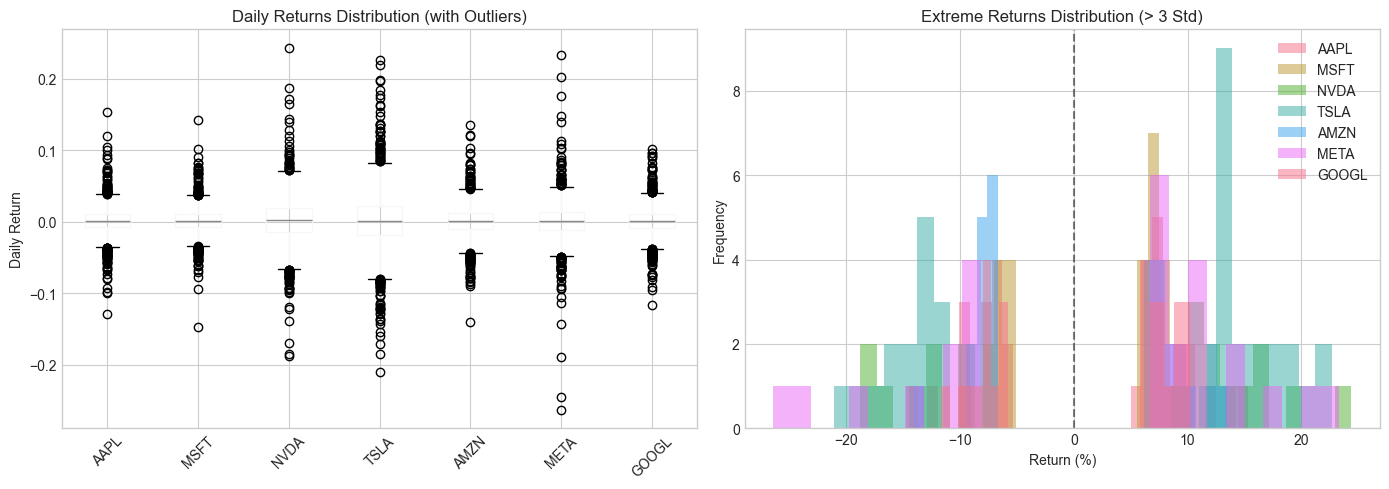

📊 Saved: data/processed/outlier_analysis.png


In [7]:
# Visualize outliers with box plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of returns
ax1 = axes[0]
daily_returns.boxplot(ax=ax1)
ax1.set_title('Daily Returns Distribution (with Outliers)', fontsize=12)
ax1.set_ylabel('Daily Return')
ax1.tick_params(axis='x', rotation=45)

# Histogram of extreme returns
ax2 = axes[1]
for ticker in TICKERS:
    returns = daily_returns[ticker].dropna()
    extreme = returns[np.abs(returns) > returns.std() * 3]
    ax2.hist(extreme * 100, bins=30, alpha=0.5, label=ticker)

ax2.set_title('Extreme Returns Distribution (> 3 Std)', fontsize=12)
ax2.set_xlabel('Return (%)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../data/processed/outlier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: data/processed/outlier_analysis.png')

In [8]:
# Decision: Keep outliers but flag them
# For stock data, extreme movements are real market events (COVID crash, earnings surprises, etc.)
# We'll create a flag column instead of removing them

def flag_outliers(df_returns, threshold=3.0):
    """
    Flag extreme returns without removing them.
    Returns DataFrame with outlier flags.
    """
    df_flags = pd.DataFrame(index=df_returns.index)
    
    for ticker in df_returns.columns:
        returns = df_returns[ticker]
        std = returns.std()
        mean = returns.mean()
        
        # Flag extreme positive and negative returns
        df_flags[f'{ticker}_extreme_pos'] = returns > (mean + threshold * std)
        df_flags[f'{ticker}_extreme_neg'] = returns < (mean - threshold * std)
        df_flags[f'{ticker}_is_extreme'] = df_flags[f'{ticker}_extreme_pos'] | df_flags[f'{ticker}_extreme_neg']
    
    return df_flags

# Create outlier flags
outlier_flags = flag_outliers(daily_returns, threshold=3.0)

# Summary of flagged days
print('🚩 EXTREME RETURN FLAGS (> 3 Std Dev)')
print('-'*50)
for ticker in TICKERS:
    extreme_count = outlier_flags[f'{ticker}_is_extreme'].sum()
    print(f'{ticker}: {extreme_count} extreme days flagged')

print(f'\n📊 Total flagged events: {outlier_flags[[f"{t}_is_extreme" for t in TICKERS]].sum().sum()}')

🚩 EXTREME RETURN FLAGS (> 3 Std Dev)
--------------------------------------------------
AAPL: 29 extreme days flagged
MSFT: 31 extreme days flagged
NVDA: 21 extreme days flagged
TSLA: 36 extreme days flagged
AMZN: 30 extreme days flagged
META: 27 extreme days flagged
GOOGL: 29 extreme days flagged

📊 Total flagged events: 203


## 5. Data Validation

In [9]:
def validate_stock_data(df, ticker):
    """
    Validate stock data for common issues.
    """
    issues = []
    
    # Check for negative prices
    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        if col in df.columns and (df[col] < 0).any():
            issues.append(f'Negative values in {col}')
    
    # Check for negative volume
    if 'Volume' in df.columns and (df['Volume'] < 0).any():
        issues.append('Negative volume detected')
    
    # Check High >= Low
    if 'High' in df.columns and 'Low' in df.columns:
        violations = (df['High'] < df['Low']).sum()
        if violations > 0:
            issues.append(f'High < Low on {violations} days')
    
    # Check High >= Close and High >= Open
    if all(col in df.columns for col in ['High', 'Low', 'Open', 'Close']):
        high_violations = ((df['High'] < df['Open']) | (df['High'] < df['Close'])).sum()
        low_violations = ((df['Low'] > df['Open']) | (df['Low'] > df['Close'])).sum()
        if high_violations > 0:
            issues.append(f'High not highest on {high_violations} days')
        if low_violations > 0:
            issues.append(f'Low not lowest on {low_violations} days')
    
    # Check for extreme price changes (> 50% in one day)
    if 'Close' in df.columns:
        pct_change = df['Close'].pct_change().abs()
        extreme_moves = (pct_change > 0.5).sum()
        if extreme_moves > 0:
            issues.append(f'{extreme_moves} days with >50% price change (check for splits)')
    
    return issues

print('✅ DATA VALIDATION REPORT')
print('='*60)

all_valid = True
for ticker in TICKERS:
    issues = validate_stock_data(stock_data_clean[ticker], ticker)
    if issues:
        all_valid = False
        print(f'\n⚠️ {ticker}:')
        for issue in issues:
            print(f'   - {issue}')
    else:
        print(f'✅ {ticker}: All validations passed')

if all_valid:
    print('\n🎉 All stocks passed validation!')

✅ DATA VALIDATION REPORT
✅ AAPL: All validations passed
✅ MSFT: All validations passed
✅ NVDA: All validations passed
✅ TSLA: All validations passed
✅ AMZN: All validations passed
✅ META: All validations passed
✅ GOOGL: All validations passed

🎉 All stocks passed validation!


## 6. Create Aligned Dataset

In [10]:
# Create a master dataset with aligned dates
# Use only dates where ALL stocks have data

# Find common dates
common_dates = None
for ticker in TICKERS:
    if common_dates is None:
        common_dates = set(stock_data_clean[ticker].index)
    else:
        common_dates = common_dates.intersection(set(stock_data_clean[ticker].index))

common_dates = sorted(list(common_dates))
print(f'📅 Common trading days: {len(common_dates)}')
print(f'   Date range: {common_dates[0].strftime("%Y-%m-%d")} to {common_dates[-1].strftime("%Y-%m-%d")}')

# Create aligned dataframes
stock_data_aligned = {}
for ticker in TICKERS:
    stock_data_aligned[ticker] = stock_data_clean[ticker].loc[common_dates].copy()
    print(f'✅ {ticker}: {len(stock_data_aligned[ticker])} rows')

📅 Common trading days: 2021
   Date range: 2018-01-02 to 2026-01-15
✅ AAPL: 2021 rows
✅ MSFT: 2021 rows
✅ NVDA: 2021 rows
✅ TSLA: 2021 rows
✅ AMZN: 2021 rows
✅ META: 2021 rows
✅ GOOGL: 2021 rows


In [12]:
# Create combined close prices dataframe (aligned)
close_prices_aligned = pd.DataFrame(index=common_dates)
for ticker in TICKERS:
    close_prices_aligned[ticker] = stock_data_aligned[ticker]['close']

# Create combined volume dataframe (aligned)
volume_aligned = pd.DataFrame(index=common_dates)
for ticker in TICKERS:
    volume_aligned[ticker] = stock_data_aligned[ticker]['volume']

# Create aligned returns
returns_aligned = close_prices_aligned.pct_change().dropna()

print('\n📊 Aligned Datasets Created:')
print(f'   Close Prices: {close_prices_aligned.shape}')
print(f'   Volume: {volume_aligned.shape}')
print(f'   Returns: {returns_aligned.shape}')


📊 Aligned Datasets Created:
   Close Prices: (2021, 7)
   Volume: (2021, 7)
   Returns: (2020, 7)


## 7. Feature Standardization

In [13]:
# Standardize column names and data types
def standardize_dataframe(df, ticker):
    """
    Standardize column names and ensure correct data types.
    """
    df_std = df.copy()
    
    # Ensure standard column names
    column_mapping = {
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'adj close': 'Adj Close',
        'volume': 'Volume'
    }
    
    # Apply mapping if needed
    df_std.columns = [column_mapping.get(col.lower(), col) for col in df_std.columns]
    
    # Ensure float type for prices
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    for col in price_cols:
        if col in df_std.columns:
            df_std[col] = df_std[col].astype(float)
    
    # Ensure int type for volume
    if 'Volume' in df_std.columns:
        df_std['Volume'] = df_std['Volume'].astype(np.int64)
    
    # Add ticker column
    df_std['Ticker'] = ticker
    
    return df_std

# Apply standardization
stock_data_final = {}
for ticker in TICKERS:
    stock_data_final[ticker] = standardize_dataframe(stock_data_aligned[ticker], ticker)

print('✅ All dataframes standardized')

# Show sample
print('\n📋 Sample (AAPL):')
display(stock_data_final['AAPL'].head())

✅ All dataframes standardized

📋 Sample (AAPL):


,Open,High,Low,Close,Volume,dividends,stock_splits,Ticker
Date,,,,,,,,
2018-01-02,39.850088,40.351258,39.639313,40.341888,102223600,0.0,0.0,AAPL
2018-01-03,40.405124,40.878192,40.271636,40.334866,118071600,0.0,0.0,AAPL
2018-01-04,40.407462,40.625262,40.299735,40.522217,89738400,0.0,0.0,AAPL
2018-01-05,40.618235,41.070224,40.526901,40.983574,94640000,0.0,0.0,AAPL
2018-01-08,40.831345,41.126425,40.732981,40.831345,82271200,0.0,0.0,AAPL


## 8. Save Cleaned Data

In [14]:
# Create cleaned data directory
os.makedirs('../data/cleaned', exist_ok=True)

# Save individual stock data
for ticker in TICKERS:
    output_path = f'../data/cleaned/{ticker}_cleaned.csv'
    stock_data_final[ticker].to_csv(output_path)
    print(f'💾 Saved: data/cleaned/{ticker}_cleaned.csv')

# Save aligned close prices
close_prices_aligned.to_csv('../data/cleaned/mag7_close_prices.csv')
print(f'💾 Saved: data/cleaned/mag7_close_prices.csv')

# Save aligned volume
volume_aligned.to_csv('../data/cleaned/mag7_volume.csv')
print(f'💾 Saved: data/cleaned/mag7_volume.csv')

# Save aligned returns
returns_aligned.to_csv('../data/cleaned/mag7_returns.csv')
print(f'💾 Saved: data/cleaned/mag7_returns.csv')

# Save outlier flags
outlier_flags.to_csv('../data/cleaned/outlier_flags.csv')
print(f'💾 Saved: data/cleaned/outlier_flags.csv')

💾 Saved: data/cleaned/AAPL_cleaned.csv
💾 Saved: data/cleaned/MSFT_cleaned.csv
💾 Saved: data/cleaned/NVDA_cleaned.csv
💾 Saved: data/cleaned/TSLA_cleaned.csv
💾 Saved: data/cleaned/AMZN_cleaned.csv
💾 Saved: data/cleaned/META_cleaned.csv
💾 Saved: data/cleaned/GOOGL_cleaned.csv
💾 Saved: data/cleaned/mag7_close_prices.csv
💾 Saved: data/cleaned/mag7_volume.csv
💾 Saved: data/cleaned/mag7_returns.csv
💾 Saved: data/cleaned/outlier_flags.csv


In [15]:
# Create a combined long-format dataset (useful for certain analyses)
combined_long = pd.concat(
    [stock_data_final[ticker] for ticker in TICKERS],
    axis=0
)
combined_long = combined_long.reset_index()
combined_long.rename(columns={'index': 'Date'}, inplace=True)

# Save combined dataset
combined_long.to_csv('../data/cleaned/mag7_combined.csv', index=False)
print(f'💾 Saved: data/cleaned/mag7_combined.csv')
print(f'   Shape: {combined_long.shape}')

# Show sample
display(combined_long.head(10))

💾 Saved: data/cleaned/mag7_combined.csv
   Shape: (14147, 9)


,Date,Open,High,Low,Close,Volume,dividends,stock_splits,Ticker
0,2018-01-02,39.850088,40.351258,39.639313,40.341888,102223600,0.0,0.0,AAPL
1,2018-01-03,40.405124,40.878192,40.271636,40.334866,118071600,0.0,0.0,AAPL
2,2018-01-04,40.407462,40.625262,40.299735,40.522217,89738400,0.0,0.0,AAPL
3,2018-01-05,40.618235,41.070224,40.526901,40.983574,94640000,0.0,0.0,AAPL
4,2018-01-08,40.831345,41.126425,40.732981,40.831345,82271200,0.0,0.0,AAPL
5,2018-01-09,40.878194,40.997631,40.611215,40.826672,86336000,0.0,0.0,AAPL
6,2018-01-10,40.552665,40.819643,40.515193,40.817299,95839600,0.0,0.0,AAPL
7,2018-01-11,40.887552,41.098327,40.864135,41.049145,74670800,0.0,0.0,AAPL
8,2018-01-12,41.259911,41.536259,41.135790,41.473026,101672400,0.0,0.0,AAPL
9,2018-01-16,41.662726,42.011674,41.250550,41.262260,118263600,0.0,0.0,AAPL


In [16]:
# Save cleaning metadata
cleaning_metadata = {
    'cleaning_date': pd.Timestamp.now().isoformat(),
    'tickers': TICKERS,
    'common_trading_days': len(common_dates),
    'date_range': {
        'start': common_dates[0].strftime('%Y-%m-%d'),
        'end': common_dates[-1].strftime('%Y-%m-%d')
    },
    'outlier_threshold': 3.0,
    'total_extreme_events': int(outlier_flags[[f"{t}_is_extreme" for t in TICKERS]].sum().sum()),
    'files_created': [
        'mag7_close_prices.csv',
        'mag7_volume.csv',
        'mag7_returns.csv',
        'mag7_combined.csv',
        'outlier_flags.csv'
    ] + [f'{t}_cleaned.csv' for t in TICKERS]
}

with open('../data/cleaned/cleaning_metadata.json', 'w') as f:
    json.dump(cleaning_metadata, f, indent=2)

print('💾 Saved: data/cleaned/cleaning_metadata.json')

💾 Saved: data/cleaned/cleaning_metadata.json


## 9. Cleaning Summary

In [17]:
print('='*70)
print('📊 DATA CLEANING SUMMARY')
print('='*70)

print(f"""
🎯 COMPLETED TASKS:

1️⃣ MISSING VALUES:
   • Checked all {len(TICKERS)} stocks for missing values
   • Applied forward-fill for price data
   • Zero-fill for missing volume

2️⃣ OUTLIER DETECTION:
   • Identified {int(outlier_flags[[f"{t}_is_extreme" for t in TICKERS]].sum().sum())} extreme return days
   • Created flag columns (not removed - real market events)
   • Threshold: 3 standard deviations

3️⃣ DATA VALIDATION:
   • Checked for negative prices (none found)
   • Validated High >= Low relationship
   • Verified price-OHLC consistency

4️⃣ DATE ALIGNMENT:
   • Common trading days: {len(common_dates)}
   • Date range: {common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}

5️⃣ STANDARDIZATION:
   • Unified column names
   • Ensured correct data types
   • Added ticker identifiers

📁 OUTPUT FILES:
   • data/cleaned/{'{ticker}'}_cleaned.csv (x7)
   • data/cleaned/mag7_close_prices.csv
   • data/cleaned/mag7_volume.csv  
   • data/cleaned/mag7_returns.csv
   • data/cleaned/mag7_combined.csv
   • data/cleaned/outlier_flags.csv
   • data/cleaned/cleaning_metadata.json

{'='*70}
✅ Data Cleaning Complete! Continue with 04_feature_engineering.ipynb
{'='*70}
""")

📊 DATA CLEANING SUMMARY

🎯 COMPLETED TASKS:

1️⃣ MISSING VALUES:
   • Checked all 7 stocks for missing values
   • Applied forward-fill for price data
   • Zero-fill for missing volume

2️⃣ OUTLIER DETECTION:
   • Identified 203 extreme return days
   • Created flag columns (not removed - real market events)
   • Threshold: 3 standard deviations

3️⃣ DATA VALIDATION:
   • Checked for negative prices (none found)
   • Validated High >= Low relationship
   • Verified price-OHLC consistency

4️⃣ DATE ALIGNMENT:
   • Common trading days: 2021
   • Date range: 2018-01-02 to 2026-01-15

5️⃣ STANDARDIZATION:
   • Unified column names
   • Ensured correct data types
   • Added ticker identifiers

📁 OUTPUT FILES:
   • data/cleaned/{ticker}_cleaned.csv (x7)
   • data/cleaned/mag7_close_prices.csv
   • data/cleaned/mag7_volume.csv  
   • data/cleaned/mag7_returns.csv
   • data/cleaned/mag7_combined.csv
   • data/cleaned/outlier_flags.csv
   • data/cleaned/cleaning_metadata.json

✅ Data Cleaning C